# Classifying Well Functionality in Tanzania

#### Why model well functionality in Tanzania?

Tanzania has struggled with finding a solution to their water crisis for years. Not only is the affordability of clean water an issue, but the infrastructure and maintenance for water has also proven to be a consistent problem for Tanzania. As a means of supporting Tanzania's sustainable development, this ongoing issue needs to be fundamentally reevaluated. Our stakeholder is Water.org, a non-government organization that is looking to implement a vast manageable amount of water pumps within the country. Before deploying teams into Tanzania blindly, they want to see how they can optimize their time and resources to effectively predict whether a water pump is functional, non existent, or just broken and needs repair. Not only is Water.org focusing on fixing non functional wells themselves, but they are also focusing on prioritizing efficiency and optimizing long term scalability.

In [1]:
# Importing relevant libraries for data exploration and cleaning
import numpy as np
import pandas as pd

In [2]:
# Pull unmodified data into notebook

X = pd.read_csv('./data/DrivenData/X_train.csv')
y = pd.read_csv('./data/DrivenData/y_train.csv')
X.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


## Interested Columns and Descriptions

### Water Quality

Water quality is non-parametric and describes the condition of the water.

This attribute is also summarized in the `quality_group` column.

The quality of the water may be an important factor in determining the longevity of the pump.

In [3]:
X.water_quality.value_counts()

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

In [4]:
X.quality_group.value_counts()

good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64

With 50818 under `good` quality, we have a very large class imbalance and its likely we won't see a difference between water quality in functional and non-functional wells. Tanzania's water, in general, appears to be in relatively good quality.

### Construction Year

The older a pump is, the more time the mechanisms and piping have had to erode. I postulate that an older pump is more likely to be in need or maintenance than a newer pump.

There is a problem with this data column:
- 20709 of our observations are NaN.
- Older pumps have fewer observations

We may be able to reconcile this data by binning pipes by age into 'New' and 'Old' pipes, where 'Old' is defined by some cut-off year. It is also likely that a large portion (or all) of our NaNs will fall into the 'Old' category, allowing us to impute our missing data with likely information without referencing other parameters.

In [5]:
X.construction_year.describe()

count    59400.000000
mean      1300.652475
std        951.620547
min          0.000000
25%          0.000000
50%       1986.000000
75%       2004.000000
max       2013.000000
Name: construction_year, dtype: float64

According to our research, wells start requiring regular maintenance after 5 years of use. Unfortunately, nearly a third of our observations are entered as a default `0`. The age of these `0` year wells are indeterminate, and with such a large number of them in the set, we don't feel comfortable imputing such a large amount of unreconcilable data.

### Source

Source may be important as it would determine the mechanism of the pump. A bore hole ground water pump will be designed differently than a rain water collecting pump. These mechanisms will have different specifications regarding wear and corrosion and may lead to different statuses given our algorithm.

In [6]:
X_source = X[[ 'source', 'source_type', 'source_class']]
X_source.head()

,source,source_type,source_class
0,spring,spring,groundwater
1,rainwater harvesting,rainwater harvesting,surface
2,dam,dam,surface
3,machine dbh,borehole,groundwater
4,rainwater harvesting,rainwater harvesting,surface


In [7]:
X_source.value_counts()

source                source_type           source_class
spring                spring                groundwater     17021
shallow well          shallow well          groundwater     16824
machine dbh           borehole              groundwater     11075
river                 river/lake            surface          9612
rainwater harvesting  rainwater harvesting  surface          2295
hand dtw              borehole              groundwater       874
lake                  river/lake            surface           765
dam                   dam                   surface           656
other                 other                 unknown           212
unknown               other                 unknown            66
dtype: int64

In [8]:
X_source.describe()

,source,source_type,source_class
count,59400,59400,59400
unique,10,7,3
top,spring,spring,groundwater
freq,17021,17021,45794


Source requires some cleaning given the use of both unknown and other in some categories. We decided to use these predictors in our final data set.

### Inflow / Outflow

The column `amount_tsh` is defined as "Total static head (amount water available to waterpoint)".

By using `amount_tsh` and `quantity` or `quantity_group` we may get some idea of whether or not the pump is working properly. As a pump that has water to draw but is not drawing water is likely in need of maintenance.

`quantity_group` and `quantity` are the same. We will drop `quantity_group` because it has the most characters in the column name.

`amount_tsh` may be problematic because of the amount of `0` inputs that cannot be differentiated from NaN or 0. May remove later because of this.

In [9]:
X_IO = X[['amount_tsh', 'quantity', 'quantity_group']]
X_IO.head()

,amount_tsh,quantity,quantity_group
0,6000.0,enough,enough
1,0.0,insufficient,insufficient
2,25.0,enough,enough
3,0.0,dry,dry
4,0.0,seasonal,seasonal


In [10]:
X_IO.value_counts()

amount_tsh  quantity      quantity_group
0.0         enough        enough            21103
            insufficient  insufficient      10914
            dry           dry                5516
            seasonal      seasonal           3411
500.0       enough        enough             2230
                                            ...  
600.0       seasonal      seasonal              1
900.0       insufficient  insufficient          1
26000.0     enough        enough                1
60000.0     enough        enough                1
350000.0    insufficient  insufficient          1
Length: 219, dtype: int64

While this data is interesting, it doesn't seem useful at a glance. We will keep it around to determine its importance using modeling methods though.

### Extraction Type

Extraction type is the actual mechanism of the pump. Different mechanisms are easier or more difficult to repair and break down at different rates. This may be more useful than source, as multiple types of mechanisms can be used for the same source type.

In [11]:
X.extraction_type_class.value_counts()

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

### Population

We're interested to see if population, the required draw and potential usage by proxy, has any effect on determining well functionality. We'll likely explore this using demographic data too. 

In [12]:
X.population.describe()

count    59400.000000
mean       179.909983
std        471.482176
min          0.000000
25%          0.000000
50%         25.000000
75%        215.000000
max      30500.000000
Name: population, dtype: float64

## Data Cleaning

Things to do:
- Concatenate XY values so if rows are removed, they are removed from both y and x data.
- Remove unwanted or clerical columns.
- Bin `construction_year` and potentially roll smaller values into `other` bins to help with class imbalance.
- Bin other columns as needed.
- Collect interested columns into a single dataframe.
- Impute or bin NaNs
- Output cleaned data to new csv for modeling purposes.

In [13]:
# Check if X and y id values are indexed appropriately
test_df = X['id'] == y['id']
test_df.value_counts()

True    59400
Name: id, dtype: int64

In [14]:
# Concatenate 'target' values from y into dataframe to keep target values indexed appropriately.

X['target'] = y.status_group

### Binning

In [15]:
# Binning construction_year into new boolean column is_new with cut-off year 'NewYear'

# Set cut-off year
NewYear = 2000

# Create new boolean column with cut-off year
X['is_new'] = X['construction_year'] >= NewYear
X.is_new.value_counts()

False    38909
True     20491
Name: is_new, dtype: int64

In [16]:
# Bin funder

X['funder'].loc[X['funder'] != 'Government Of Tanzania'] = 'Other'

C:\Users\Mouse\anaconda3\envs\learn-env\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [17]:
# Creating new column to bin scheme_management
X['scheme_class'] = X['scheme_management']

In [18]:
# Bin scheme_management as scheme_class

replace_dict = {'Parastatal' : 'Government',
                'Water authority' : 'Government',
                'WUA' : 'Government',
                'WUG' : 'Government',
                'VWC' : 'Government',
                'SWC' : 'Government',
                'Water Board' : 'Government', 
                'Private operator' : 'Other',
                'Trust' : 'Other',
                'Company' : 'Other',
                'None' : 'None',
                np.NaN : 'None'}

X.scheme_class.replace(replace_dict, inplace=True)

In [19]:
X.scheme_class.value_counts()

Government    52560
None           3878
Other          2962
Name: scheme_class, dtype: int64

In [20]:
## Binning Installer

# Making everything uppercase for sorting purposes
X['installer'] = X.installer.str.upper()

In [21]:
# Consolidating government installers into Government.

# Creating dictionary for fine tooth combing of data entries
imputer = {'GOVERNMENT' : 'Government',
           'DWE' : 'Government',
           'RWE' : 'Government',
           'WIZARA  YA MAJI' : 'Government',
           'COMMU' : 'Government',
           '0' : 'Other',
           'DANIDA' : 'Private',
           'HESAWA' : 'Private',
           'KKKT' : 'Private',
           'CENTRAL GOVERNMENT' : 'Government',
           'TCRS' : 'Private',
           'COMMUNITY' : 'Other',
           'CES' : 'Private',
           'DANID' : 'Private',
           'DISTRICT COUNCIL' : 'Government',
           'WORLD VISION' : 'Private',
           'LGA' : 'Government',
           'WEDECO' : 'Private',
           'TASAF' : 'Government',
           'GOVER' : 'Government',
           'AMREF' : 'Private',
           'TWESA' : 'Government',
           'WU' : 'Private',
           'DMDD' : 'Other',
           'ACRA' : 'Private',
           'FINI WATER' : 'Other',
           'NORAD' : 'Private',
           'DA' : 'Government',
           'SEMA' : 'Private',
           'DW' : 'Other',
           'JAICA' : 'Private',
           'OXFAM' : 'Private',
           'UNICEF' : 'Private',
           'SHIPO' : 'Private',
           'IDARA YA MAJI' : 'Government',
           'GOVE' : 'Government',
           'VILLAGERS' : 'Other',
           'SENGEREMA WATER DEPARTMENT' : 'Government',
           'KILIWATER' : 'Private',
           'FINW' : 'Private',
           'RC CHURCH' : 'Private',
           'DH' : 'Government',
           'KUWAIT' : 'Private',
           'DWSP' : 'Government',
           'DISTRI' : 'Government',
           'LAWATEFUKA WATER SUP' : 'Government',
           'RC' : 'Government',
           'MAGADINI-MAKIWARU WA' : 'Other',
           'DISTRICT WATER DEPARTMENT' : 'Government',
           'FW' : 'Other',
           'KKKT _ KONDE AND DWE' : 'Other',
           'PRIVATE' : 'Private',
           'CENTR' : 'Other',
           'WVT' : 'Private'}

# Replacing combed data using the dictionary.
X.installer.replace(imputer, inplace=True)

# Binning NaNs into Other
X.installer.fillna('Other', inplace=True)

# Checking existing entries for unique values
X.installer.value_counts()

Government              27013
Private                 10101
Other                    6895
MWE                       157
IS                        156
                        ...  
VIFAI                       1
BABU SAJIN                  1
PRINCE MEDIUM SCHOOL        1
RC MSUFI                    1
SERIKARI                    1
Name: installer, Length: 1884, dtype: int64

In [22]:
# Iterate through remaining values and replace with bulk Other
# This column requires more fine-tooth combing regarding binning given that following our brief definition foray,
#      there are still 1884 unique rows with < 157 entries that amount to near 20,000, or approximately 30% of the
#      full data set's entries. Because of our binning method, Other will likely be oversampled.

for i in X['installer'].values:
    if i != 'Government':
        if i != 'Private':
            if i != 'Other':
                X.installer.replace({i:'Other'}, inplace=True)

In [23]:
# Checking to see if bulk replacement worked
X.installer.value_counts()

Government    27013
Other         22286
Private       10101
Name: installer, dtype: int64

### Column Selection

In [24]:
# Defining lists for both physical and political traits to enter into final data set.

# Physical traits for model:
cols1 = ['is_new', 'extraction_type_class', 'amount_tsh', 'quantity', 
         'source_type', 'source_class', 'quality_group', 'population', 
         'target']

# Political traits for model
cols2 = ['funder', 'num_private', 'region',
         'scheme_class', 'permit', 'payment', 
         'source', 'installer']

In [25]:
# Dropping columns we're not interested in or do not make sense for analysis.

# Set list of kept columns for concatenation
keep_cols = cols1 + cols2

# New dataframe with kept columns
df = X[keep_cols]

In [26]:
# Display cleaned data frame
df

,is_new,extraction_type_class,amount_tsh,quantity,source_type,source_class,quality_group,population,target,funder,num_private,region,scheme_class,permit,payment,source,installer
0,False,gravity,6000.0,enough,spring,groundwater,good,109,functional,Other,0,Iringa,Government,False,pay annually,spring,Other
1,True,gravity,0.0,insufficient,rainwater harvesting,surface,good,280,functional,Other,0,Mara,Other,True,never pay,rainwater harvesting,Other
2,True,gravity,25.0,enough,dam,surface,good,250,functional,Other,0,Manyara,Government,True,pay per bucket,dam,Private
3,False,submersible,0.0,dry,borehole,groundwater,good,58,non functional,Other,0,Mtwara,Government,True,never pay,machine dbh,Private
4,False,gravity,0.0,seasonal,rainwater harvesting,surface,good,0,functional,Other,0,Kagera,None,True,never pay,rainwater harvesting,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,False,gravity,10.0,enough,spring,groundwater,good,125,functional,Other,0,Kilimanjaro,Government,True,pay per bucket,spring,Private
59396,False,gravity,4700.0,enough,river/lake,surface,good,56,functional,Other,0,Iringa,Government,True,pay annually,river,Other
59397,False,handpump,0.0,enough,borehole,groundwater,fluoride,0,functional,Other,0,Mbeya,Government,False,pay monthly,machine dbh,Other
59398,False,handpump,0.0,insufficient,shallow well,groundwater,good,0,functional,Other,0,Dodoma,Government,True,never pay,shallow well,Other


### Dealing with NaNs

In [27]:
# Checking for null values to deal with

for i in df.columns:
    print(f'{i} has {df[i].isna().sum()} null values')

is_new has 0 null values
extraction_type_class has 0 null values
amount_tsh has 0 null values
quantity has 0 null values
source_type has 0 null values
source_class has 0 null values
quality_group has 0 null values
population has 0 null values
target has 0 null values
funder has 0 null values
num_private has 0 null values
region has 0 null values
scheme_class has 0 null values
permit has 3056 null values
payment has 0 null values
source has 0 null values
installer has 0 null values


In [28]:
# Set replacement dictionary for permit NaNs
# For column permits we have these values associated with management schemes:
#
#       Government: we assume true because government entities likely have the political authority to permit wells.
#       Other: We assume false because the entity is unknown or not a government entity and errors here effect only
#              a small amount of entries.
#       None: We assume false because the source either predates permitting or was likely installed without permit 
#             and errors here effect only a small amount of entries.

imputer = {'Government' : True,
           'Other' : False,
           'None' : False}

df.permit.fillna(df.scheme_class.map(imputer), inplace=True)

C:\Users\Mouse\anaconda3\envs\learn-env\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [29]:
# Checking status of nulls in columns before moving onto next process

for i in df.columns:
    print(f'{i} has {df[i].isna().sum()} null values')

is_new has 0 null values
extraction_type_class has 0 null values
amount_tsh has 0 null values
quantity has 0 null values
source_type has 0 null values
source_class has 0 null values
quality_group has 0 null values
population has 0 null values
target has 0 null values
funder has 0 null values
num_private has 0 null values
region has 0 null values
scheme_class has 0 null values
permit has 0 null values
payment has 0 null values
source has 0 null values
installer has 0 null values


In [30]:
# Write cleaned dataframe to csv file for modeling

df.to_csv(path_or_buf = "./Data/df_clean.csv", header=True)

---

# Modeling

### Preliminary Modeling EDA and Engineering

+ Visualize data for potential patterns
+ dummy model
+ DecisionTree to determine important predictors
+ Model
 - Simple logistic regression
 - More complex model


**Where necessary:**
- Train/Test Split
- Encode Categorical Data
- Fix imbalances where necessary.

In [31]:
# import relevant libraries
import matplotlib.pyplot as plt

In [32]:
# ignore warnings (there are a lot of them)
import warnings
warnings.filterwarnings('ignore')

In [33]:
# Read in cleaned dataset.
# (not necessary on this notebook. But the originals were split into two for efficiency and neatness)
df = pd.read_csv('./data/df_clean.csv')

# Dummy Classifier

We now want to model based of the political factors of our dataset, organizing how political variables affect the overall functionality versus our other physical characteristics. We are also going to use precision as our overall metric.

In [34]:
# importing relevant libraries
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score

In [35]:
# seperating interested columns out into new dataframe
political_col = ['funder', 'num_private', 'region', 
                'scheme_class', 'payment',
                 'source','target', 'permit', 'installer']
df_pol = df[political_col]

In [36]:
# Performing test-train split
y = df_pol['target']
X = df_pol.drop(columns = ['target'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [37]:
# Performing dummy classification
pol_clf = DummyClassifier(strategy="most_frequent")
pol_clf.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent');

In [38]:
# Scoring dummy classifier

print(f'Our dummy classifier has a precision of: \
      {round(precision_score(y_train, pol_clf.predict(X_train), average = "weighted", zero_division=0),3)*100}%')

Our dummy classifier has a precision of:       29.4%


## OneHot Encode and Decision Trees

Using decision trees to define our important features for future models.

In [39]:
# Import relevant libraries
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [40]:
# Encode the X_train and X_test dataframes
ohe = OneHotEncoder(handle_unknown = 'ignore', sparse = False)

# Encode train set
X_train_ohe1 = ohe.fit_transform(X_train)
X_train_ohe = pd.DataFrame(X_train_ohe1)
X_train_ohe.columns = ohe.get_feature_names(X_train.columns)

# Encode train set
X_test_ohe1 = ohe.transform(X_test)
X_test_ohe = pd.DataFrame(X_test_ohe1)
X_test_ohe.columns = ohe.get_feature_names(X_test.columns)

In [41]:
# Decision tree

clf = DecisionTreeClassifier(criterion='entropy', max_depth = 3)

clf.fit(X_train_ohe, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

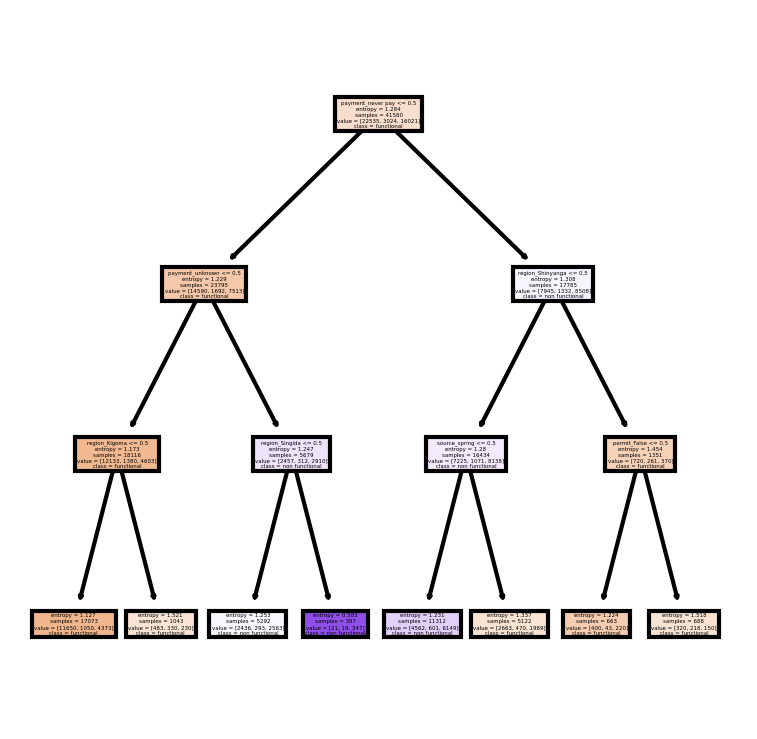

In [42]:
fig, axes = plt.subplots(nrows = 1,ncols =1 , figsize = (3,3), dpi=300)
plot_tree(clf,
               feature_names = X_train_ohe.columns, 
               class_names=np.unique(y).astype('str'),
               filled = True)
plt.show()

### Decision Tree Results

**Top 4 features in order:**

- Payment
- Region
- Permit
- Source 

## Simple Logistic Regression

We'll start our modeling with a simple logistic regression since our target variable is categorical.

In [43]:
# Importing relevant libraries
from sklearn.linear_model import LogisticRegression

In [44]:
# Column selection
log_cols1 = ['permit', 'region', 'payment', 'source']

logx_train = X_train[log_cols1]
logx_test = X_test[log_cols1]

In [45]:
# Encoding new frames
logx_train_ohe1 = ohe.fit_transform(logx_train)
logx_train_ohe = pd.DataFrame(logx_train_ohe1)
logx_train_ohe.columns = ohe.get_feature_names(logx_train.columns)

logx_test_ohe1 = ohe.transform(logx_test)
logx_test_ohe = pd.DataFrame(logx_test_ohe1)
logx_test_ohe.columns = ohe.get_feature_names(logx_test.columns)

In [46]:
# Instantiate and perform logistic regression

logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')

logreg.fit(logx_train_ohe, y_train)

print(f"Training precision: \
      {round(precision_score(y_train, logreg.predict(logx_train_ohe), average='weighted', zero_division=0),4)*100}%")
print(f"Test precision: \
      {round(precision_score(y_test, logreg.predict(logx_test_ohe), average='weighted', zero_division=0),4)*100}%")

Training precision:       57.45%
Test precision:       57.07%


#### Logistic Regression Results

While 57% precision is a large increase from the 29.4% of our dummy model, we feel this is still not good enough of a model since its only 7% above determining a functioning well by guess.

## K-Nearest Neighbors Model

Given suspected relationship between regions and permit status, we feel a KNN model may perform better than our logistic regression.

In [47]:
# Import relevant libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

In [48]:
# Validation split from our X_train
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train,
                                          random_state=42,
                                          test_size=0.3)

In [49]:
# Encoding validation frames
X_te = ohe.fit_transform(X_t)
X_vale = ohe.transform(X_val)

In [50]:
# Instantiate and run KNN models
knn = KNeighborsClassifier()

knn.fit(X_te, y_t)
print(f"Training precision: \
      {round(precision_score(y_t, knn.predict(X_te), average='weighted', zero_division=0),4)*100}%")
print(f"Validation precision: \
      {round(precision_score(y_val, knn.predict(X_vale), average='weighted', zero_division=0),4)*100}%")

Training precision:       66.08000000000001%
Validation precision:       62.53999999999999%


### Model Tuning using K-Fold

We're using K-Fold to tune our hyperparameters for our KNN model (n_neighbors specifically).

**Highest precision at n_neighbors = 18**

We will run the model again, specifying a n_neighbors of 18.

In [51]:
knn = KNeighborsClassifier(n_neighbors=18)

knn.fit(X_te, y_t)
print(f"Training precision: \
      {round(precision_score(y_t, knn.predict(X_te), average='weighted', zero_division=0),4)*100}%")
print(f"Validation precision: \
      {round(precision_score(y_val, knn.predict(X_vale), average='weighted', zero_division=0),4)*100}%")

Training precision:       66.59%
Validation precision:       64.99000000000001%


This is better, but if we bin our targets into a binary set, we may have better results.

Since a well that is functioning but needs repair is still a well that requires maintenance, we will bin the `functional but needs repair` class into `non functional`. This will result in the former being regarded as requiring attention by the model.

In [52]:
# Binning targets
y_ = pd.DataFrame(y)

y_.replace({'functional needs repair' : 'non functional'}, inplace=True)
print(y_.value_counts())

target        
functional        32259
non functional    27141
dtype: int64


**Highest precision at n_neighbors = 20**

We can run the model at a n_neighbors of 20.

In [53]:
# performing a new validation split with the binned targets
X_t, X_val, y_t_, y_v_ = train_test_split(X, y_, test_size = 0.3, random_state = 42)

X_te = ohe.fit_transform(X_t)
X_vale = ohe.transform(X_val)

In [54]:
knn = KNeighborsClassifier(n_neighbors = 20)

knn.fit(X_te, y_t_)

print(f"Training precision: \
      {round(precision_score(y_t_, knn.predict(X_te), average='weighted', zero_division=0),4)*100}%")
print(f"Validation precision: \
      {round(precision_score(y_v_, knn.predict(X_vale), average='weighted', zero_division=0),4)*100}%")

Training precision:       70.64%
Validation precision:       69.24%


In [67]:
y_t_

,target
43069,non functional
58858,functional
41707,non functional
30674,functional
20944,functional
...,...
54343,functional
38158,functional
860,non functional
15795,functional


### SMOTE work

We can also go about fixing imbalance issues with `target` for the 'functioning needs maintenance' using SMOTE.

In [55]:
# import relevant libraries
from imblearn.over_sampling import SMOTE

In [71]:
# Encoding for SMOTE process
X_e1 = ohe.fit_transform(X)
X_e = pd.DataFrame(X_e1)
X_e.columns = ohe.get_feature_names(X.columns)

# Balancing train set
sm = SMOTE(random_state = 42)
X_res, y_res = sm.fit_resample(X_e, y)

In [72]:
y_res

0            functional
1            functional
2            functional
3        non functional
4            functional
              ...      
96772    non functional
96773    non functional
96774    non functional
96775    non functional
96776    non functional
Name: target, Length: 96777, dtype: object

In [74]:
# Export SMOTE dataframes to CSV for use on other machines without having to run through all the code again

# Cast as dataframes
X_res = pd.DataFrame(X_res)
y_res = pd.DataFrame(y_res)

X_res.to_csv(path_or_buf = "./Data/X_SMOTE.csv", header=True, index=False)
y_res.to_csv(path_or_buf = "./Data/Y_SMOTE.csv", header=True, index=False)

In [75]:
# Import SMOTE dataframes from CSV for use on other machines

X_res = pd.read_csv('./Data/X_SMOTE.csv', index_col = False)
y_res = pd.read_csv('./Data/Y_SMOTE.csv', index_col = False)

In [76]:
y_res

,target
0,functional
1,functional
2,functional
3,non functional
4,functional
...,...
96772,non functional
96773,non functional
96774,non functional
96775,non functional


In [77]:
# Validation split
X_res_train, X_res_test, y_res_train, y_res_test = train_test_split(X_res, y_res,
                                                                   test_size = 0.3,
                                                                   random_state = 42)

In [78]:
y_res_train

,target
26018,functional
46466,non functional
62793,functional needs repair
65847,functional needs repair
12187,functional
...,...
6265,functional
54886,functional
76820,functional needs repair
860,non functional


In [ ]:
# Perform default KNN
knn = KNeighborsClassifier()

knn.fit(X_res_train, y_res_train)
print(f"Training precision: \
      {round(precision_score(y_res_train, knn.predict(X_res_train), average='weighted', zero_division=0),4)*100}%")
print(f"Test precision: \
      {round(precision_score(y_res_test, knn.predict(X_res_test), average='weighted', zero_division=0),4)*100}%")

We may be able to improve on this model by optimizing our hyperparameters.